<a href="https://colab.research.google.com/github/satyamsingh1004/ML/blob/master/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random

In [0]:
# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device_gpu)

cuda:0


# English & Hindi Alphabet Setup

In [0]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [0]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

# Data

In [0]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

In [0]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch

In [0]:
train_data = TransliterationDataLoader('NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('NEWS2012-Ref-EnHi-1000.xml')

Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD  -  आज़मनगर
Skipping:  CAPE TOWN  -  केपटाउन
Skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND  -  राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA  -  जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping:  FAKHRUN NISA  -  फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping:  OPENTV  -  ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP  

In [0]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20543
Test Set Size:	 1000

Sample data from train-set:
HUNGARIAN - हंगेरियन
BHAI - भाई
GRAMMY - ग्रैमी
EMERSON - इमर्सन
FARRUKH - फारुख
TURNER - टर्नर
PRALHAD - प्रहलाद
LAHIAH - लहियाह
AMORY - एमोरी
TO - तो


In [0]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [0]:
eng, hindi = train_data.get_random_sample()
eng_rep = word_rep(eng, eng_alpha2index)
print(eng, eng_rep)

GARIBON tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [0]:
hindi_gt = gt_rep(hindi, hindi_alpha2index)
print(hindi, hindi_gt)

गरीबों tensor([[24],
        [49],
        [65],
        [45],
        [76],
        [ 3],
        [ 0]])


# Network

In [0]:
def infer(net, eng, shape, device="cpu"):
  input = word_rep(eng, eng_alpha2index, device)
  outputs = net(input, shape, device)
  return outputs

In [0]:
##Encoder-Decoder with Attention
MAX_OUTPUT_CHARS = 30

class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [0]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose=True)

In [0]:
out = infer(net_attn, 'HATIM', 20)

Encoder output torch.Size([6, 256])
Decoder state torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 129])
U * Encoder output torch.Size([6, 256])
W * Decoder state torch.Size([6, 256])
V torch.Size([6, 1])
Attn torch.Size([1, 6])
Attn LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


In [0]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

20
torch.Size([1, 129]) ॊ
torch.Size([1, 129]) आ
torch.Size([1, 129]) आ
torch.Size([1, 129]) ा
torch.Size([1, 129]) ा
torch.Size([1, 129]) ा
torch.Size([1, 129]) ा
torch.Size([1, 129]) ा
torch.Size([1, 129]) ॽ
torch.Size([1, 129]) ॽ
torch.Size([1, 129]) ॽ
torch.Size([1, 129]) म
torch.Size([1, 129]) ा
torch.Size([1, 129]) ा
torch.Size([1, 129]) ा
torch.Size([1, 129]) ा
torch.Size([1, 129]) ा
torch.Size([1, 129]) ॽ
torch.Size([1, 129]) ॽ
torch.Size([1, 129]) ॽ


## Training

###Core Trainer

In [0]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        input = word_rep(eng_batch[i], eng_alpha2index, device)
        gt = gt_rep(hindi_batch[i], hindi_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

###Training Helper

In [0]:
def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    incorrect = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = gt_rep(hindi, hindi_alpha2index, device)
        outputs = infer(net, eng, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
            else:
              incorrect += 1;
              print(eng,hindi,incorrect)
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

In [0]:
import time

def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
  
    start_time = time.time()
    
    loss = []
    acc = []
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='max', factor=0.1, patience=20, verbose=True,min_lr=0.00001)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        accuracy = calc_accuracy(net) * 100
        acc.append(accuracy)
        loss.append(loss_arr[i])
        #scheduler.step(accuracy)
        
        if i%display_freq == display_freq-1:
            #clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i], 'Accuracy', accuracy, 'Time Elapsed: ', time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
            #plt.figure()
            #plt.plot(loss_arr[1:i], '-*')
            #plt.xlabel('Iteration')
            #plt.ylabel('Loss')
            #plt.show()
            #print('\n\n')
            
    plt.figure()
    plt.plot(loss, 'r')
    plt.plot(acc, 'g')
    plt.xlabel('Iteration')
    plt.ylabel('Loss/Accuracy')
    plt.show()
            
    torch.save(net, 'model.pt')
    return loss_arr

###Training with Attention

In [0]:
net_att = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 19 Loss 0.08827939629554749 Accuracy 20.62438311688311 Time Elapsed:  00:06:43
Iteration 39 Loss 0.07860015332698822 Accuracy 28.595281662781645 Time Elapsed:  00:13:28
Iteration 59 Loss 0.07028491795063019 Accuracy 41.46706460206457 Time Elapsed:  00:20:11
Iteration 79 Loss 0.06207268312573433 Accuracy 50.921631979131924 Time Elapsed:  00:26:52
Iteration 99 Loss 0.0547790564596653 Accuracy 54.80269758019758 Time Elapsed:  00:33:39
Iteration 119 Loss 0.048999760299921036 Accuracy 59.75038156288151 Time Elapsed:  00:40:23
Iteration 139 Loss 0.04441913962364197 Accuracy 61.94795010545009 Time Elapsed:  00:47:04
Iteration 159 Loss 0.040815673768520355 Accuracy 62.873869186369205 Time Elapsed:  00:53:50
Iteration 179 Loss 0.03782760351896286 Accuracy 63.58605561105555 Time Elapsed:  01:00:40
Iteration 199 Loss 0.03527497127652168 Accuracy 65.80123210123207 Time Elapsed:  01:07:25
Iteration 219 Loss 0.033179156482219696 Accuracy 67.49843656343658 Time Elapsed:  01:14:15
Iteration 

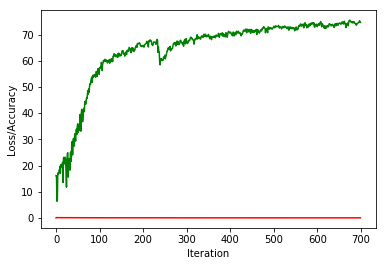

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Transliteration_EncoderDecoder_Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
loss_history = train_setup(net_att, lr=0.01, n_batches=700, batch_size = 256, display_freq=20, device = device_gpu)

## Inference

In [0]:
def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, word, 30, device)
    hindi_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        hindi_char = hindi_alphabets[index+1]
        hindi_output += hindi_char
    print(word + ' - ' + hindi_output)
    return hindi_output

In [0]:
accuracy_attn = calc_accuracy(net_att) * 100
print('Acurracy with attention', accuracy_attn)

AAYASHA आयशा 1
AAYASHA आयशा 2
ABDUH अब्दुस 3
ABERHART एबरहर्ट 4
ABEY अबेय 5
ABOU अबू 6
ABRI एब्री 7
ABRI एब्री 8
ACCOMMODATION एकोमडेशन 9
ACCOMMODATION एकोमडेशन 10
ACCOMMODATION एकोमडेशन 11
ACCOMMODATION एकोमडेशन 12
ACCOMMODATION एकोमडेशन 13
ACORN एकोर्न 14
ADGAON अदगांव 15
ADLABS एडलेब्स 16
ADLABS एडलेब्स 17
ADLABS एडलेब्स 18
ADLABS एडलेब्स 19
ADLABS एडलेब्स 20
ADLABS एडलेब्स 21
AHLAAD आह्लाद 22
AIR एअर 23
AISIN एसिन 24
AKHRI आखिरी 25
AKODIA अकोडिया 26
AKURDI अकुर्डी 27
ALAS अलास 28
ALAS अलास 29
ALBANY अलबाने 30
ALBANY अलबाने 31
ALBANY अलबाने 32
ALBANY अलबाने 33
ALBANY अलबाने 34
ALIPUR अलीपुर 35
ALKALI अल्कली 36
AMANAT अमानत 37
AMANAT अमानत 38
AMANAT अमानत 39
ANNA अन्ना 40
ANNA अन्ना 41
ANNE एनी 42
ANNE एनी 43
ANTIBODY एंटीबॉडी 44
ARAAFAT अराफात 45
ARAAFAT अराफात 46
ARIES एरीज 47
ARK आर्क 48
ARMAN अरमान 49
ARMS आर्म्स 50
ARNOTT आरनॉट 51
ARNOTT आरनॉट 52
ARSIKERE अरसिकेरी 53
ARSIKERE अरसिकेरी 54
ARSIKERE अरसिकेरी 55
ARSIKERE अरसिकेरी 56
ARSIKERE अरसिकेरी 57
ARTHURTON अर्थर्टन 58
ARTHURT

In [0]:
out = infer(net_att, 'YOGESH', 30)

In [0]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) य
torch.Size([1, 129]) ो
torch.Size([1, 129]) ग
torch.Size([1, 129]) े
torch.Size([1, 129]) श
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
